In [41]:
import numpy as np
import cv2
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Вхідна матриця
image = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 255, 0, 0, 255, 0, 0],
    [0, 255, 63, 127, 127, 63, 255, 0],
    [0, 0, 127, 0, 0, 127, 0, 0],
    [0, 0, 127, 0, 0, 127, 0, 0],
    [0, 255, 63, 127, 127, 63, 255, 0],
    [0, 0, 255, 0, 0, 255, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])

# Функція для вейвлет-перетворення
def apply_dwt(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return LL, (LH, HL, HH)

# Рекурсивне застосування перетворення
def multi_level_dwt(image, levels):
    results = []
    current_image = image
    for _ in range(levels):
        LL, (LH, HL, HH) = apply_dwt(current_image)
        results.append((LL, LH, HL, HH))
        current_image = LL  # Для наступного рівня беремо LL
    return results

# Виведення числових матриць
results = multi_level_dwt(image, levels=3)

for i, (LL, LH, HL, HH) in enumerate(results):
    print(f"\nРівень {i + 1}")
    print("LL (Низькі частоти):")
    print(np.round(LL, 2))  # Округлення до двох десяткових для зручності

    print("\nLH (Горизонтальні високі частоти):")
    print(np.round(LH, 2))

    print("\nHL (Вертикальні високі частоти):")
    print(np.round(HL, 2))

    print("\nHH (Діагональні високі частоти):")
    print(np.round(HH, 2))




Рівень 1
LL (Низькі частоти):
[[  0.  127.5 127.5   0. ]
 [127.5 158.5 158.5 127.5]
 [127.5 158.5 158.5 127.5]
 [  0.  127.5 127.5   0. ]]

LH (Горизонтальні високі частоти):
[[   0.  -127.5 -127.5    0. ]
 [ 127.5   31.5   31.5  127.5]
 [-127.5  -31.5  -31.5 -127.5]
 [   0.   127.5  127.5    0. ]]

HL (Вертикальні високі частоти):
[[   0.   127.5 -127.5    0. ]
 [-127.5   31.5  -31.5  127.5]
 [-127.5   31.5  -31.5  127.5]
 [   0.   127.5 -127.5    0. ]]

HH (Діагональні високі частоти):
[[   0.  -127.5  127.5    0. ]
 [-127.5  -95.5   95.5  127.5]
 [ 127.5   95.5  -95.5 -127.5]
 [   0.   127.5 -127.5    0. ]]

Рівень 2
LL (Низькі частоти):
[[206.75 206.75]
 [206.75 206.75]]

LH (Горизонтальні високі частоти):
[[-79.25 -79.25]
 [ 79.25  79.25]]

HL (Вертикальні високі частоти):
[[-79.25  79.25]
 [-79.25  79.25]]

HH (Діагональні високі частоти):
[[-48.25  48.25]
 [ 48.25 -48.25]]

Рівень 3
LL (Низькі частоти):
[[413.5]]

LH (Горизонтальні високі частоти):
[[0.]]

HL (Вертикальні висок

# Load image

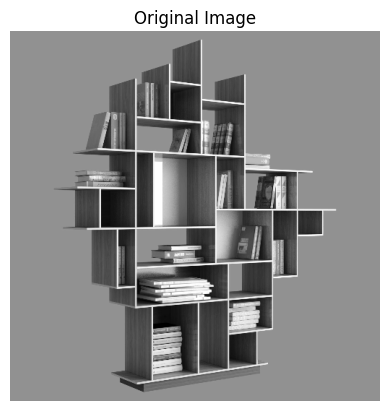

In [42]:
image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

image = cv2.resize(image, (512, 512))

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


#  DCT (Дискретне косинусне перетворення)

In [43]:
# Розбиття на блоки 8×8 і застосування DCT

def apply_dct(image):
    height, width = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)
    
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = image[i:i+8, j:j+8]
            dct_block = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
            dct_image[i:i+8, j:j+8] = dct_block
    
    return dct_image


In [44]:
# Компресія: залишаємо лише верхні коефіцієнти

def compress_dct(dct_image, keep_coeff=8):
    compressed = np.zeros_like(dct_image)
    height, width = dct_image.shape
    
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = dct_image[i:i+8, j:j+8]
            # Залишаємо верхній лівий квадрат розміром keep_coeff x keep_coeff
            block[:keep_coeff, :keep_coeff] = block[:keep_coeff, :keep_coeff]
            compressed[i:i+8, j:j+8] = block
            
    return compressed


In [45]:
def dct_manual(block):
    N = block.shape[0]
    dct_result = np.zeros_like(block, dtype=np.float32)
    alpha = lambda x: 1 / np.sqrt(2) if x == 0 else 1

    for u in range(N):
        for v in range(N):
            sum = 0
            for x in range(N):
                for y in range(N):
                    sum += block[x, y] * np.cos(((2 * x + 1) * u * np.pi) / (2 * N)) * np.cos(((2 * y + 1) * v * np.pi) / (2 * N))
            dct_result[u, v] = 0.25 * alpha(u) * alpha(v) * sum
    return dct_result

In [46]:
# Обернене DCT

def apply_idct(dct_image):
    height, width = dct_image.shape
    reconstructed = np.zeros_like(dct_image, dtype=np.float32)
    
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = dct_image[i:i+8, j:j+8]
            idct_block = idct(idct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
            reconstructed[i:i+8, j:j+8] = idct_block
            
    return np.clip(reconstructed, 0, 255).astype(np.uint8)


In [47]:
def idct_manual(block):
    N = block.shape[0]
    idct_result = np.zeros_like(block, dtype=np.float32)
    alpha = lambda x: 1 / np.sqrt(2) if x == 0 else 1

    for x in range(N):
        for y in range(N):
            sum = 0
            for u in range(N):
                for v in range(N):
                    sum += alpha(u) * alpha(v) * block[u, v] * np.cos(((2 * x + 1) * u * np.pi) / (2 * N)) * np.cos(((2 * y + 1) * v * np.pi) / (2 * N))
            idct_result[x, y] = 0.25 * sum
    return np.clip(idct_result, 0, 255)

# DWT (Дискретне вейвлет-перетворення)

In [48]:
def apply_dwt(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return LL, (LH, HL, HH)

In [49]:
def compress_dwt(LL):
    return np.round(LL)

In [4]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Вхідна матриця
image = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 255, 0, 0, 255, 0, 0],
    [0, 255, 63, 127, 127, 63, 255, 0],
    [0, 0, 127, 0, 0, 127, 0, 0],
    [0, 0, 127, 0, 0, 127, 0, 0],
    [0, 255, 63, 127, 127, 63, 255, 0],
    [0, 0, 255, 0, 0, 255, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])

# Функція для вейвлет-перетворення
def apply_dwt(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return LL, (LH, HL, HH)

# Рекурсивне застосування перетворення
def multi_level_dwt(image, levels):
    results = []
    current_image = image
    for _ in range(levels):
        LL, (LH, HL, HH) = apply_dwt(current_image)
        results.append((LL, LH, HL, HH))
        current_image = LL  # Для наступного рівня беремо LL
    return results

# Виконання вейвлет-перетворення на трьох рівнях
results = multi_level_dwt(image, levels=3)

# Візуалізація результатів
for i, (LL, LH, HL, HH) in enumerate(results):
    print(f'Level {i+1}')
    print(f'LL:\n{LL}')
    print(f'LH:\n{LH}')
    print(f'HL:\n{HL}')

    


Level 1
LL:
[[  0.  127.5 127.5   0. ]
 [127.5 158.5 158.5 127.5]
 [127.5 158.5 158.5 127.5]
 [  0.  127.5 127.5   0. ]]
LH:
[[   0.  -127.5 -127.5    0. ]
 [ 127.5   31.5   31.5  127.5]
 [-127.5  -31.5  -31.5 -127.5]
 [   0.   127.5  127.5    0. ]]
HL:
[[   0.   127.5 -127.5    0. ]
 [-127.5   31.5  -31.5  127.5]
 [-127.5   31.5  -31.5  127.5]
 [   0.   127.5 -127.5    0. ]]
Level 2
LL:
[[206.75 206.75]
 [206.75 206.75]]
LH:
[[-79.25 -79.25]
 [ 79.25  79.25]]
HL:
[[-79.25  79.25]
 [-79.25  79.25]]
Level 3
LL:
[[413.5]]
LH:
[[0.]]
HL:
[[0.]]


In [50]:
def dwt_haar_manual(image):
    image = image.astype(np.float32)

    height, width = image.shape
    LL = np.zeros((height // 2, width // 2))
    LH = np.zeros((height // 2, width // 2))
    HL = np.zeros((height // 2, width // 2))
    HH = np.zeros((height // 2, width // 2))
    
    for i in range(0, height, 2):
        for j in range(0, width, 2):
            # Отримуємо блок 2x2
            a = image[i, j]
            b = image[i, j + 1]
            c = image[i + 1, j]
            d = image[i + 1, j + 1]
            
            # Обчислення компонент
            LL[i // 2, j // 2] = (a + b + c + d) / 4
            LH[i // 2, j // 2] = (a - b + c - d) / 4
            HL[i // 2, j // 2] = (a + b - c - d) / 4
            HH[i // 2, j // 2] = (a - b - c + d) / 4

    return LL, LH, HL, HH

In [52]:
def apply_idwt(LL, coeffs):
    return pywt.idwt2((LL, coeffs), 'haar')

In [53]:
def idwt_haar_manual(LL, LH, HL, HH):
    height, width = LL.shape
    reconstructed = np.zeros((height * 2, width * 2), dtype=np.float32)



    for i in range(height):
        for j in range(width):
            # Відновлення блоку 2x2
            a = LL[i, j] + LH[i, j] + HL[i, j] + HH[i, j]
            b = LL[i, j] - LH[i, j] + HL[i, j] - HH[i, j]
            c = LL[i, j] + LH[i, j] - HL[i, j] - HH[i, j]
            d = LL[i, j] - LH[i, j] - HL[i, j] + HH[i, j]
            
            # Розміщення у відновленому зображенні
            reconstructed[i * 2, j * 2] = a
            reconstructed[i * 2, j * 2 + 1] = b
            reconstructed[i * 2 + 1, j * 2] = c
            reconstructed[i * 2 + 1, j * 2 + 1] = d

    return np.clip(reconstructed, 0, 255).astype(np.uint8)

# Застосування та порівняння

In [54]:
def calculate_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # Без втрат
    max_pixel = 255.0
    psnr = 10 * np.log10(max_pixel ** 2 / mse)
    return psnr

## Бібліотечна імплементація

(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

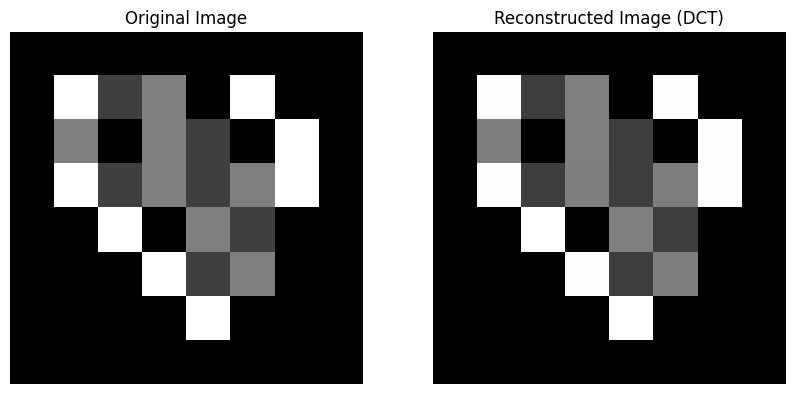

In [55]:
dct_image = apply_dct(image)
compressed_dct = compress_dct(dct_image, keep_coeff=4)
reconstructed_dct_lib = apply_idct(compressed_dct)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image (DCT)")
plt.imshow(reconstructed_dct_lib, cmap='gray')
plt.axis('off')

## Ручна імплементція

(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

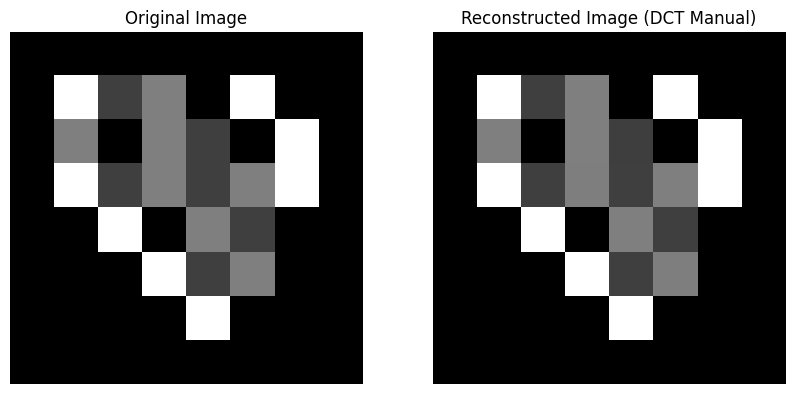

In [56]:
# Розбиття на блоки 8x8 і застосування DCT вручну
block_size = 8
height, width = image.shape
compressed_dct = np.zeros_like(image, dtype=np.float32)

# Пряме DCT
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        block = image[i:i+block_size, j:j+block_size]
        compressed_dct[i:i+block_size, j:j+block_size] = dct_manual(block)

# Обернене DCT
reconstructed_dct_man = np.zeros_like(image, dtype=np.float32)
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        block = compressed_dct[i:i+block_size, j:j+block_size]
        reconstructed_dct_man[i:i+block_size, j:j+block_size] = idct_manual(block)
reconstructed_dct_man = reconstructed_dct_man.astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image (DCT Manual)")
plt.imshow(reconstructed_dct_man, cmap='gray')
plt.axis('off')

## Бібліотечна імплементація

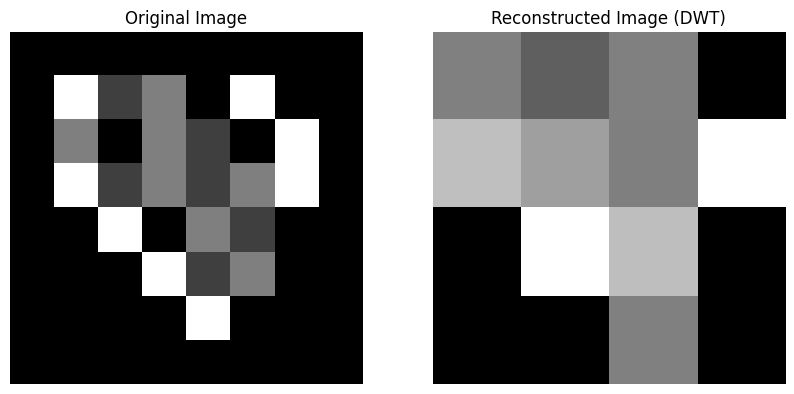

In [57]:
LL, coeffs = apply_dwt(image)
compressed_LL = compress_dwt(LL)
reconstructed_dwt_lib = apply_idwt(compressed_LL, (np.zeros_like(coeffs[0]), 
                                               np.zeros_like(coeffs[1]), 
                                               np.zeros_like(coeffs[2])))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image (DWT)")
plt.imshow(reconstructed_dwt_lib, cmap='gray')
plt.axis('off')

plt.show()

## Ручна імплементація

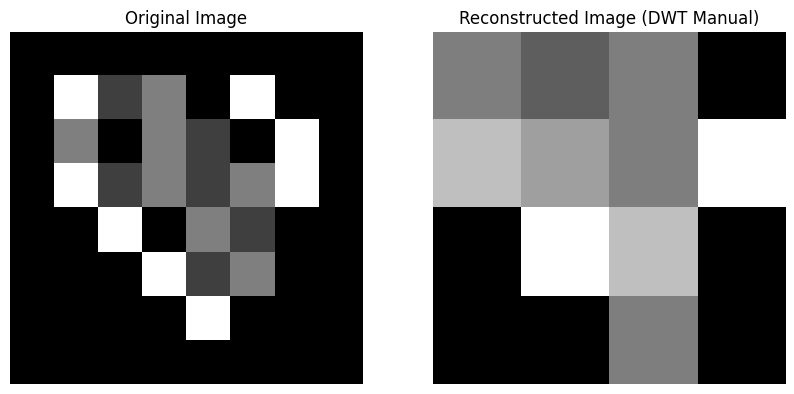

In [58]:
LL, LH, HL, HH = dwt_haar_manual(image)
compressed_LL = LL.copy()
reconstructed_dwt_man = idwt_haar_manual(compressed_LL, np.zeros_like(LH), np.zeros_like(HL), np.zeros_like(HH))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image (DWT Manual)")
plt.imshow(reconstructed_dwt_man, cmap='gray')
plt.axis('off')

plt.show()

In [59]:
psnr_dct_lib = calculate_psnr(image, reconstructed_dct_lib)
psnr_dwt_lib = calculate_psnr(image, reconstructed_dwt_lib)
psnr_dct_man = calculate_psnr(image, reconstructed_dct_man)
psnr_dwt_man = calculate_psnr(image, reconstructed_dwt_man)

print(f"PSNR для DCT lib: {psnr_dct_lib:.2f} dB")
print(f"PSNR для DCT man: {psnr_dct_man:.2f} dB")
print(f"PSNR для DWT lib: {psnr_dwt_lib:.2f} dB")
print(f"PSNR для DWT man: {psnr_dwt_man:.2f} dB")


PSNR для DCT lib: 54.73 dB
PSNR для DCT man: 61.42 dB
PSNR для DWT lib: 10.69 dB
PSNR для DWT man: 10.69 dB
